### Part 1: Heterogeneous treatment effects using causal trees and forests

For this part, we will be using experimental data for computing heterogeneous effects through causal trees and forests. For all exercises, the predictors $ X $ are all variables that are not the outcome $Y$ or the treatment 
$ D$.

In [440]:
import Pkg
Pkg.add(["CSV", "GLM", "MLJ", "MLJModels", "MLJScikitLearnInterface", "MLJDecisionTreeInterface", "Plots", "CategoricalArrays", "StatsPlots"])

   Resolving package versions...
  No Changes to `C:\Users\almen\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\almen\.julia\environments\v1.10\Manifest.toml`


In [441]:
using CSV, DataFrames, Statistics, GLM, MLJ, MLJModels, Plots, CategoricalArrays, StatsPlots

1.1. Load the data (1 points).

In [442]:
df1 = CSV.read("C:\\Users\\almen\\OneDrive\\Escritorio\\ASS5\\CausalAI-Course\\Labs\\Assignment\\Assignment_5\\data\\experimental\\experimental_control.csv", DataFrame)
first(df1, 5)

Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,37,11,1,0,1,1,0.0,0.0,9930.05
2,1,22,9,0,1,0,1,0.0,0.0,3595.89
3,1,30,12,1,0,0,0,0.0,0.0,24909.4
4,1,27,11,1,0,0,1,0.0,0.0,7506.15
5,1,33,8,1,0,0,1,0.0,0.0,289.79


1.2. Find the ATE (1.5 points). With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM). What can you say about the program?

In [443]:
# DIFFERENCE OF MEANS
# treated
treatment_group = filter(row -> row.treat == 1, df1)
mean_treatment = mean(treatment_group.re78)

# control
control_group = filter(row -> row.treat == 0, df1)
mean_control = mean(control_group.re78)

# ATE (Diferencia Simple de Medias)
ATE = mean_treatment - mean_control

println("ATE (Simple Difference of Means): ", ATE)

ATE (Simple Difference of Means): 1794.3423818501024


In [444]:
# OTHER WAY TO CALCULATE THE ATE
# OLS
model = lm(@formula(re78 ~ treat), df1)
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

re78 ~ 1 + treat

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4554.8      408.046  11.16    <1e-24   3752.85     5356.75
treat        1794.34     632.853   2.84    0.0048    550.574    3038.11
───────────────────────────────────────────────────────────────────────

The treatment has an average effect of : 1794.34

The ATE of 1794.34 indicates that, on average, people who participated in the job training program (treatment) had  1,794.34 more in real income in 1978 compared to those who did not participate (control group).

1.3. Heterogeneous effects with causal trees (3 points). Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable 
Y
∗
 and fit a decision tree regressor. Report the splits the tree finds and interpret them.

In [445]:
y, X = unpack(df1, ==(:re78), !=(:re78))
# coerce!(X, Textual => Multiclass)
coerce!(X, Count => MLJ.Continuous)
D, X = unpack(X, ==(:treat), !=(:treat))
D = categorical(D)

445-element CategoricalArray{Float64,1,UInt32}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [446]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface verbosity=0

log_model = LogisticClassifier()

log_model_machine = machine(log_model,X, D)

fit!(log_model_machine)

┌ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
└ @ MLJBase C:\Users\almen\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
C:\Users\almen\.julia\environments\v1.10\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\almen\.julia\environments\v1.10\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_res

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @053 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @080 ⏎ AbstractVector{Multiclass{2}}


In [447]:
pscore = pdf.(MLJ.predict(log_model_machine, X),1)
y_star = df1.re78 ./ (df1.treat .* pscore .- (1 .- df1.treat) .* (1 .- pscore));

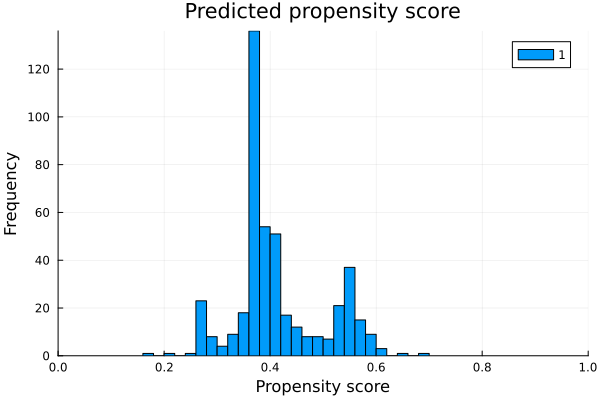

In [448]:
histogram(pscore, bins=30, title="Predicted propensity score", label = "1",
         xlabel="Propensity score", ylabel="Frequency",xlims=(0, 1))

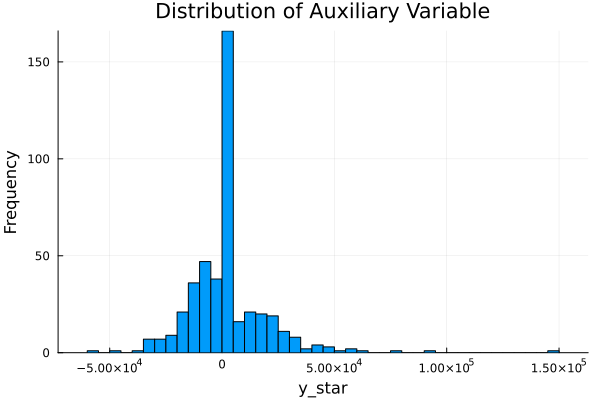

In [449]:
histogram(y_star, bins=50, title="Distribution of Auxiliary Variable", label = false,
         xlabel="y_star", ylabel="Frequency")     

In [450]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)

tree_model = DecisionTreeRegressor(max_depth = 2)
tree_machine = machine(tree_model, X, y_star)
fit!(tree_machine);

┌ Info: Training machine(DecisionTreeRegressor(max_depth = 2, …), …).
└ @ MLJBase C:\Users\almen\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


In [451]:
fitted_params(tree_machine)[1]

educ < 13.5
├─ re74 < 2653.0
│  ├─ 2057.6227542105853 (0/353)
│  └─ -2046.5338277229378 (0/83)
└─ 18389.164319002033 (0/9)


Interpretation:

The causal tree indicates the program's impact varies significantly based on education and prior earnings (re74). Participants with less education (educ < 13.5) and lower prior earnings (re74 < 2653.0) experience moderate positive effects, while those in the same education group but higher prior earnings see negative effects. Conversely, participants with more education (educ ≥ 13.5) observe significantly higher impacts. This highlights the importance of education and prior earnings in predicting program success.

1.4. Heterogeneous effects with causal forests (3 points). Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable 
Y
∗
 computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables.


In [452]:
RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree verbosity = 0

forest_model = RandomForestRegressor(n_trees = 100)
forest_machine = machine(forest_model, X, y_star)
fit!(forest_machine);

┌ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).
└ @ MLJBase C:\Users\almen\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


In [453]:
# OJO:
fitted_params(forest_machine)[1]

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 176.34
Avg Depth:  19.6

In Julia we have the limitation that when we fit Random Forests, it generates an Ensemble of decision trees. By definition this is correct; however, we do not have access to the singular trees, for this reason  we cannot visualize a more interpretable individual tree. 

OJO:Stil, we are able to see the feature importances.

In [454]:
feature_importances(forest_machine)

8-element Vector{Pair{Symbol, Float64}}:
      :age => 0.33229322931362865
     :re75 => 0.24218329704977815
     :educ => 0.16040252613874853
     :re74 => 0.13778417141969512
     :marr => 0.03878155455122939
    :black => 0.03830822007224275
 :nodegree => 0.025739700963929253
     :hisp => 0.02450730049074807

In [455]:
importances = DataFrame(feature_importances(forest_machine))
importances = DataFrame(variables = names(importances), importance = collect(values(importances[1, :])))

Row,variables,importance
,String,Float64
1,age,0.332293
2,re75,0.242183
3,educ,0.160403
4,re74,0.137784
5,marr,0.0387816
6,black,0.0383082
7,nodegree,0.0257397
8,hisp,0.0245073


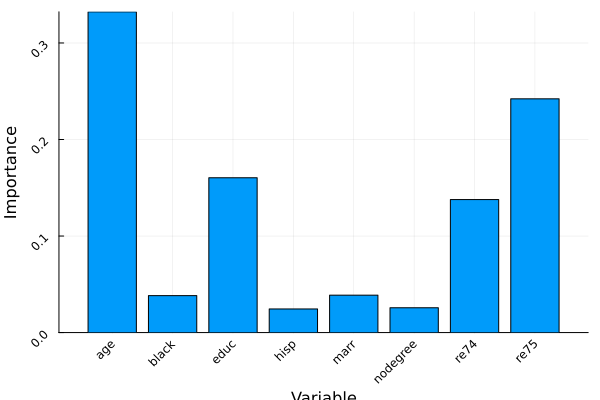

In [456]:
importances.variables = categorical(importances.variables, ordered=true)
sort!(importances, :importance, rev=false)

@df importances bar(:variables, :importance, legend=false)
plot!(xlabel="Variable", ylabel="Importance", xticks=(1:length(importances.variables), levels(importances.variables)), rotation=45)
     

The variable importance analysis highlights age as the most influential predictor of the treatment effect, followed by re75 and educ. This suggests that factors such as age and prior earnings are critical in determining outcomes. Other variables like marital status (marr), race (black, hisp), and educational attainment (nodegree) have relatively lower importance, indicating a lesser role in predicting the effect. 

1.5. Plot heterogeneous effects (1.5 points). Plot how the predicted treatment effect changes depending on a variable of your choice.

In [457]:
# predicted effects
predicted = MLJ.predict(forest_machine, X)
df1.predicted_effect = predicted


# bins for: 're74', 're75', 'age' y 'educ' 
df1.re74_bins = floor.(df1.re74 ./ 500) .* 500
df1.re75_bins = floor.(df1.re75 ./ 500) .* 500
df1.age_bins = floor.(df1.age ./ 5) .* 5
df1.age_bins .= ifelse.(df1.age_bins .== 15, 17, df1.age_bins)

445-element Vector{Real}:
 35.0
 20.0
 30.0
 25.0
 30.0
 20.0
 20.0
 30.0
 20.0
 30.0
  ⋮
 25.0
 25.0
 20.0
 40.0
 20.0
 25.0
 25.0
 25.0
 20.0

In [458]:
# re74_bins
re74_effect_bins = combine(groupby(df1, :re74_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(re74_effect_bins, :re74_bins)

# re75_bins
re75_effect_bins = combine(groupby(df1, :re75_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(re75_effect_bins, :re75_bins)

# age_bins
age_effect_bins = combine(groupby(df1, :age_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(age_effect_bins, :age_bins)

# educ
educ_effect_bins = combine(groupby(df1, :educ), :predicted_effect => mean => :mean_predicted_effect)
sort!(educ_effect_bins, :educ)

Row,educ,mean_predicted_effect
,Int64,Float64
1,3,-475.648
2,4,7357.36
3,5,14132.6
4,6,-1482.48
5,7,-1254.28
6,8,521.587
7,9,1003.41
8,10,80.1535
9,11,2434.64


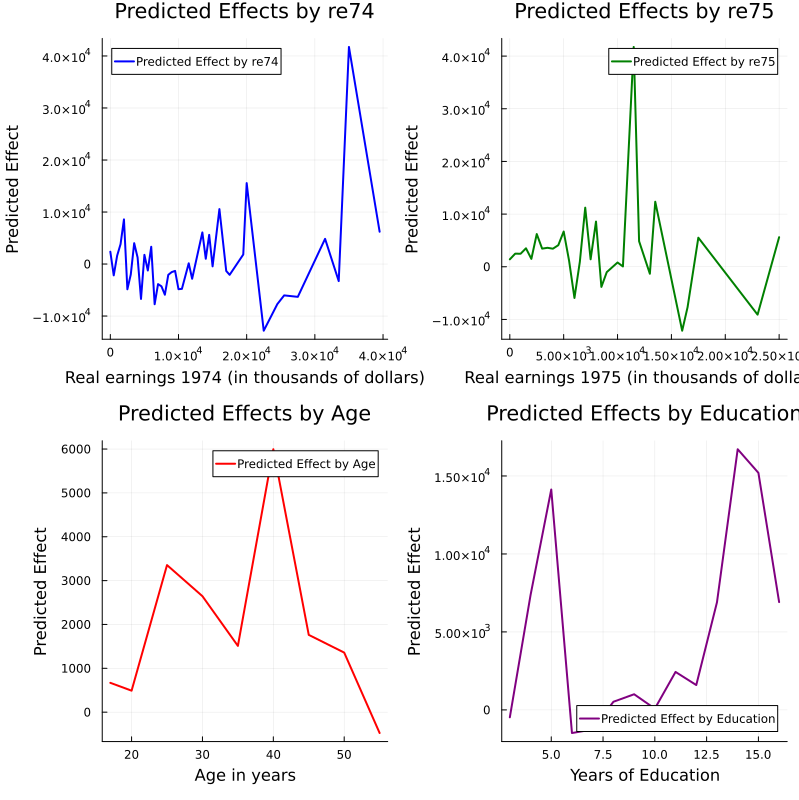

In [459]:
# Graphics:
p1 = plot(re74_effect_bins.re74_bins, re74_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by re74", color=:blue, xlabel="Real earnings 1974 (in thousands of dollars)", 
          ylabel="Predicted Effect", lw=2, title="Predicted Effects by re74")

p2 = plot(re75_effect_bins.re75_bins, re75_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by re75", color=:green, xlabel="Real earnings 1975 (in thousands of dollars)", 
          ylabel="Predicted Effect", lw=2, title="Predicted Effects by re75")

p3 = plot(age_effect_bins.age_bins, age_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by Age", color=:red, xlabel="Age in years", ylabel="Predicted Effect", 
          lw=2, title="Predicted Effects by Age")

p4 = plot(educ_effect_bins.educ, educ_effect_bins.mean_predicted_effect, 
          label="Predicted Effect by Education", color=:purple, xlabel="Years of Education", 
          ylabel="Predicted Effect", lw=2, title="Predicted Effects by Education")


plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))